In [1]:
from IPython.core.display import display, HTML, Javascript

In [2]:
import os 
os.getcwd()

'E:\\researches\\MusicVAE'

In [3]:
from src.params import *
from src.model import VariationalAutoencoder
import matplotlib.pyplot as plt
from src.midi_builder_new import MidiBuilderNew
from src.new_model import VAECell
import IPython.display

In [4]:
# m_key_count
m_key_count

3

In [5]:
from src.data_utils import MidiDataset, BarTransform
from torch.autograd import Variable #deprecated!!!

In [6]:
''' 
Create model and load state dict from path
'''
def loadModel(path):
    model = VAECell(latent_features)
    model.load_state_dict(torch.load(path, map_location=device))
    model.eval()

    return model

In [7]:
model = loadModel('records/2020_04_27_15_22_55.pt')
model = model.to(device)

Use attention type dot


In [8]:
#builder = MidiBuilderNew()

In [9]:
# transform = BarTransform(bars=totalbars, note_count=NUM_PITCHES)
# midi_dataset = MidiDataset(csv_file='piano_rolls_a_small_fraction.csv', transform = transform)
# dataset_size = len(midi_dataset)           #number of musics on dataset
# test_size = int(test_split * dataset_size) #test size length
# train_size = dataset_size - test_size      #train data length
# train_dataset, test_dataset = random_split(midi_dataset, [train_size, test_size])
# test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size, num_workers=1)#, sampler=test_sampler)


In [10]:
# x = next(iter(test_loader))
# x = Variable(x['piano_rolls'].type('torch.FloatTensor'))

# x = x.to(device)

# #model.set_scheduled_sampling(1.)  # Please use teacher forcing for validations
# outputs = model(x)

In [11]:
# x.shape

In [12]:
# x_hat = outputs['multi_notes']
# x = x.to("cpu")
# x_hat = x_hat.to("cpu")

In [13]:
# multi_notes_np = x_hat.detach().numpy()
# x_np = x.detach().numpy()

In [14]:
import glob
DATA_PATH = "E:/researches/MusicVAE/data/maestro-v2.0.0/"
SEARCH_CRITERION = '**/*.midi'

midi_files = glob.glob(os.path.join(DATA_PATH, SEARCH_CRITERION), recursive=True)

In [15]:
midi_files[0]

'E:/researches/MusicVAE/data/maestro-v2.0.0\\2004\\MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_05_Track05_wav.midi'

In [16]:
from src.data_utils import transposer, encode_dummies, chopster, trim_blanks, minister
import pretty_midi

In [17]:
from music21 import *

In [18]:
from sklearn import decomposition
from sklearn import datasets

In [19]:
majors = dict([("A-", 4), ("G#", 4), ("A", 3), ("A#", 2), ("B-", 2),
               ("B", 1), ("C", 0), ("C#", -1), ("D-", -1), ("D", -2),
               ("D#", -3), ("E-", -3), ("E", -4), ("F", -5), ("F#", 6),
               ("G-", 6), ("G", 5)])
# Minor conversion
minors = dict([("G#", 1), ("A-", 1), ("A", 0), ("A#", -1), ("B-", -1),
               ("B", -2), ("C", -3), ("C#", -4), ("D-", -4), ("D", -5),
               ("D#", 6), ("E-", 6), ("E", 5), ("F", 4), ("F#", 3),
               ("G-", 3), ("G", 2)])

In [20]:
value2majors = {6:"F# G-", 5:"G", 4:"A- G#", 3:"A", 2:"A# B-", 1:"B", 
                0:"C", -1:"C# D-", -2:"D", -3:"D# E-", -4:"E",-5:"F"}

In [21]:
X = []
Y = []
note_count = 512

for i in range(100):
    try:
        score = converter.parse(midi_files[i])
        alto = score.parts[0]
        excerpt = alto.measures(0, note_count // 16)

        key = excerpt.analyze("key")
        print(key.tonic.name)
        print(key.mode)

        if key.mode == "major":
            halfSteps = majors[key.tonic.name]
        else:  # key.mode == "minor":
            halfSteps = minors[key.tonic.name]

        y = np.repeat(halfSteps, 512)

        pm = pretty_midi.PrettyMIDI(midi_files[i])

        if len(pm.instruments) > 1:
            raise Exception(
                "Sorry, deal with the MIDI pieces that have one instrument")

        sampling_freq = 1 / (pm.get_beats()[1] / 4)
        instrument = pm.instruments[0]

        piano_rolls = encode_dummies(instrument, sampling_freq).fillna(value=0)
        piano_rolls.values.shape

        #encode midi to data frame
        piano_rolls = encode_dummies(instrument, sampling_freq).fillna(value=0)

        #cut the data to record the music note only from c3 to b7
        piano_rolls = chopster(piano_rolls)

        #trim the beginning empty sound track
        piano_rolls = trim_blanks(piano_rolls)

        #Ignore the strength(velocity) and regard the sound as one and non-sound as zero
        piano_rolls = minister(piano_rolls)

        silence_col = np.zeros((piano_rolls.shape[0], 1))

        piano_rolls_with_silences = np.append(piano_rolls, silence_col, axis=1)

        sample = piano_rolls_with_silences.astype('float')

        # Fill in 1's for the silent rows
        empty_rows = ~sample.any(axis=1)
        if len(sample[empty_rows]) > 0:
            sample[empty_rows, -1] = 1.

        s = torch.from_numpy(sample).type('torch.FloatTensor')
        s = s.unsqueeze(0)
        s = s.to(device)

        #model.set_scheduled_sampling(1.)  # Please use teacher forcing for validations
        output_s = model(s[:,:note_count,:])

        s_mu = output_s['mu']
        s_mu_np = s_mu.cpu().detach().numpy()
        s_mu_np = s_mu_np[0]

        X.append(s_mu_np)
        Y.append(y)
    except:
        print("wrong index", i)
        continue

meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 1 of 
[None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 5 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/partial/left>>, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.b

D
major


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 3 of 
[None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 3 of 
[None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 

F
minor


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 7 of 
[None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/stop>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 17 of 
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.bea

D
minor


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 10 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/continue>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/continue>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/partial/left>>, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, 

G
major


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 6 of 
[None, None, None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 4 of 
[None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/s

A-
major


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 15 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/stop>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/partial/left>>, None, None, None, None, None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<

A
minor


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 22 of 
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 2 of 
[None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/st

A
major


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 2 of 
[None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 3 of 
[None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop

C
minor


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 2 of 
[None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 9 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/partial/left>>, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Be

A-
major


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 4 of 
[None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 3 of 
[None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam

meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 7 of 
[None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/continue>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]


B-
minor


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 8 of 
[None, None, None, None, None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 4 of 
[None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.b

C#
minor


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 9 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/stop>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/partial/left>>, None, None, None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 5 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam

F
major


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 12 of 
[None, None, None, None, None, None, None, None, None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 9 of 
[None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/stop>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/partial/left>>, None, <music21.beam.Beams <music21.beam.Beam 1/start>>, <music21.beam.Bea

C
minor


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 6 of 
[None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]


A
major


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 18 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, None, None, None, None, None, None, None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/continue>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.

G
minor


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 11 of 
[None, None, None, None, None, None, None, None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 11 of 
[None, None, None, None, None, None, None, None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music

A
major


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 3 of 
[None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]


D
minor


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 12 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/stop>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, None, None, None, None, None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 10 of 
[<music21.beam.Beams <music21.

meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 12 of 
[None, None, None, None, None, None, None, None, None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 1 of 
[None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <mu

E-
major
wrong index 18


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 13 of 
[None, None, None, None, None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]


F
major


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 1 of 
[None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 9 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/partial/left>>, None, None, None, None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]


G
major


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 7 of 
[None, None, None, None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 6 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <

A-
major


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 4 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]


C#
minor


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 1 of 
[None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 2 of 
[None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]


E-
minor
A
minor
G#
minor


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 3 of 
[None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 10 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/stop>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/partial/left>>, None, None, <mus

A-
major


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 7 of 
[None, None, None, None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 3 of 
[None, <music21.beam.Beams <music21.beam.Beam 1/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/

B-
minor


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 2 of 
[None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 11 of 
[None, None, None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARN

E
minor
G
minor


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 6 of 
[None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/stop>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/partial/left>>, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 3 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>>, <music21.beam.Beams <music21.beam.Beam 1/continue>>, <music21.beam.Beams <music21.be

D
minor


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 12 of 
[None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/part

meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 4 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>/<music21.beam.Beam 3/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]


G
minor
F#
major


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 2 of 
[None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 3 of 
[None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop

E-
major


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 16 of 
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 8 of 
[None, <music21.beam.Beams <music21.beam.Beam 1/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/partial/left>>, None, <music21.beam.Beams <music21.beam.Beam 1/start>>, <music21.beam.Beams <music21.beam.Beam 1/continue>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<

C
minor


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 15 of 
[None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, None, None, None, None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 4 of 
[<music21.beam.Beams <music21.beam.Beam 1/start

G
minor


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 20 of 
[None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/stop>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, None, None, None, None, None, None, None, None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beam

F#
minor


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 18 of 
[None, None, None, None, None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, None, None, None, None, None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 12 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Bea

D
minor


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 12 of 
[None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, None, None, None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 11 of 
[<music21.beam.Beams <music21.beam.Be

C
minor


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 4 of 
[None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 4 of 
[None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music2

A-
major


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 2 of 
[None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 5 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/partial/left>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <m

meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 11 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, None, None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/continue>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/stop>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.b

B
minor


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 2 of 
[None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 12 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, None, None, None, None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/stop>>, <music21.beam.Beams <music2

G
major
D
major


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 6 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 5 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/st

meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 8 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/partial/left>>, None, <music21.beam.Beams <music21.beam.Beam 1/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 4 of 
[None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music2

A
minor


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 7 of 
[None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 6 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/continue>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<

B
major


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 1 of 
[None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 2 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>

A-
major


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 4 of 
[None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/continue>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 4 of 
[None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING

F
minor


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 10 of 
[None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/continue>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/stop>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/partial/left>>, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 2 of 
[<music21.beam.Beams <music21.be

meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 3 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/stop>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 6 of 
[None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, <music21.beam.Beams <music21

C#
major
G#
minor


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 2 of 
[None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 11 of 
[None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/continue>>, <music21.beam.Beams <music21.beam.Beam 1/partial/left>/<music21.beam.Beam 2/stop>>, None, None, None, None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <musi

B-
minor


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 1 of 
[None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]


B-
minor


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 16 of 
[None, None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/partial/left>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/continue>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, None, None, None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/

meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 2 of 
[None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]


B-
major


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 1 of 
[None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 1 of 
[None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 7 of 

A
minor


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 15 of 
[None, None, None, None, None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, None, None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 15 of 
[None, None, None, None, None, None, None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <m

C
major


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 3 of 
[None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]


G#
minor


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 18 of 
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 13 of 
[None, None, None, None, None, None, None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, <music21.beam.Beams <music21.beam.Be

F#
minor


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 8 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/stop>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/stop>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/sta

F
minor


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 5 of 
[None, None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 22 of 
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <mu

C#
major


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 1 of 
[None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 2 of 
[None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index

G
major


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 3 of 
[None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 6 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <musi

meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 8 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/continue>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]


D
major


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 5 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/continue>>, <music21.beam.Beams <music21.beam.Beam 1/continue>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/partial/left>>, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 17 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.

meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 8 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>>, <music21.beam.Beams <music21.beam.Beam 1/continue>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/partial/left>>, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/stop>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/partial/left>/<music21.beam.Beam 2/stop>>, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.bea

C
major


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 1 of 
[None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 11 of 
[None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/stop>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, None, None, None, None, <music21.beam.Beams <music21.b

meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 20 of 
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]


B-
minor


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 5 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/stop>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 5 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/stop>>, <music21.beam.Bea

meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 5 of 
[None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/continue>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 5 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, <music21.beam.Beams <music21.beam.Beam 1/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop

A-
major


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 8 of 
[None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/continue>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/partial/left>>, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 6 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>/<music21.beam.Beam 3/partial/right>>, <music21.beam.Beams

A-
major


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 5 of 
[None, None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 9 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/stop>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/partial/left>>, None, None, None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, 

meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 10 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/continue>>, <music21.beam.Beams <music21.beam.Beam 1/continue>>, <music21.beam.Beams <music21.beam.Beam 1/continue>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/partial/left>>, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/stop>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/

E-
major


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 5 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/continue>>, <music21.beam.Beams <music21.beam.Beam 1/continue>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 6 of 
[None, None, None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <musi

D
minor


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 2 of 
[None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 12 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>/<music21.beam.Beam 3/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, None, None, None, None, None, None, None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop

C#
major


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 2 of 
[None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 3 of 
[None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop

C
minor
B-
major


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 3 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 3 of 
[None, <music21.beam.Beams <music21.beam.Beam 1/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.B

G
major


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 11 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 4 of 
[None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/parti

E
minor


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 3 of 
[None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 12 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, None, None, None, None, <music21.beam.Beams <music21.beam.Bea

D
minor


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 3 of 
[None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 5 of 
[None, None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music2

E-
major


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 5 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 5 of 
[None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams

C
minor


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 4 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/stop>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 6 of 
[None, None, None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.bea

B
minor


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 8 of 
[None, None, <music21.beam.Beams <music21.beam.Beam 1/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/partial/left>>, None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 13 of 
[None, None, None, None, None, None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/continue>>, <music2

B
major


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 3 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 4 of 
[None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.be

B
major


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 2 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 7 of 
[None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/sto

E-
major


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 10 of 
[None, None, None, None, None, None, None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 11 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, None, None, 

meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 13 of 
[None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, None, None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 16 of 
[None, None, None, None, None, 

E-
major


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 1 of 
[None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 5 of 
[None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.

E
major
C#
major


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 7 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/continue>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/stop>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/partial/left>>, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, 

C
major


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 9 of 
[None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 4 of 
[None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam 

F#
minor


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 5 of 
[None, None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 10 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.

E
minor


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 3 of 
[None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 1 of 
[None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at

A
major


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 5 of 
[None, None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]


B-
major


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 1 of 
[None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 2 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>

B
major


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 5 of 
[None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 2 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <

D
minor


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 3 of 
[None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]


F
minor
D
minor


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 3 of 
[None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 3 of 
[None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.

B-
major


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 6 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/continue>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]


C#
minor
B-
major


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 4 of 
[None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 7 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/partial/left>>, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/stop>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/part

C
minor


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 13 of 
[None, None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, None, None, None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 7 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, None, None, <music2

F
major
A
minor


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 4 of 
[None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 6 of 
[None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <musi

A-
major


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 6 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/partial/left>>, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/continue>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 3 of 
[None, None, None, <music21.beam.Beams <musi

meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 4 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/partial/left>>, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 14 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/stop>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/start>>, <music21

meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 4 of 
[None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 10 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/stop>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.

B-
minor


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 7 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/continue>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/continue>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/stop>>, <music21.beam.Beams <music21.beam.Beam 1/continue>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/partial/left>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21

meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 11 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/stop>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/continue>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/stop>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<mu

D
minor


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 2 of 
[None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 2 of 
[None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at

A
major


In [22]:
#alto = score.parts[0]

In [23]:
#excerpt = alto.measures(0, 16)

In [24]:
#print(excerpt.analyze("key").tonic.name)
#print(excerpt.analyze("key").mode)

In [25]:
X_stack = np.vstack(X)
Y_stack = np.hstack(Y)

In [26]:
from sklearn import preprocessing

In [27]:
scaler = preprocessing.StandardScaler().fit(X_stack)
X_stack_scaled = scaler.transform(X_stack)

In [28]:
pca = decomposition.PCA(n_components=3)
pca.fit(X_stack_scaled)
X_stack_pca = pca.transform(X_stack_scaled)

In [29]:
X_stack_pca.shape

(50688, 3)

In [30]:
# plt.scatter(X_stack_pca[:, 0], X_stack_pca[:, 1], c=Y_stack, cmap=plt.cm.nipy_spectral,
#            alpha=0.2, edgecolors='none')
# plt.legend()
# plt.show()

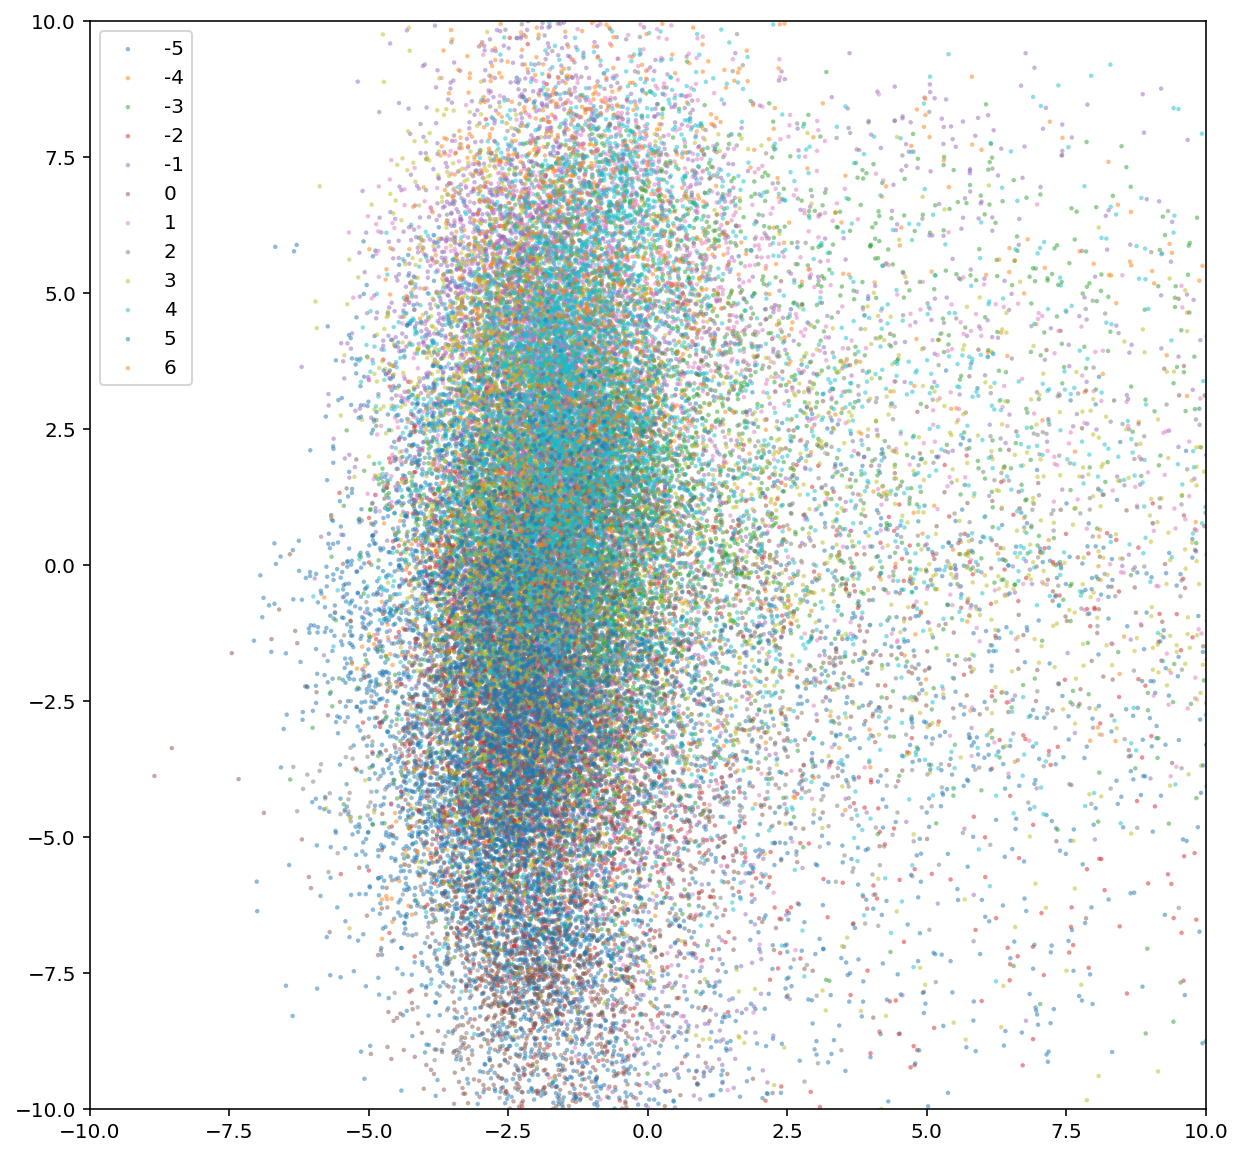

In [31]:
fig, ax = plt.subplots(figsize=(10,10))
for g in np.unique(Y_stack):
    ix = np.where(Y_stack == g)
    ax.scatter(X_stack_pca[ix, 0], X_stack_pca[ix, 1], label = g, alpha=0.5, s = 5, edgecolors='none')
ax.legend()
plt.xlim((-10, 10))
plt.ylim((-10, 10))

plt.show()

In [32]:
X_stack_pca.shape

(50688, 3)

In [33]:
Y_stack.shape

(50688,)

In [34]:
Y_stack_array = np.array([Y_stack]).transpose()

In [35]:
Y_stack_array.shape

(50688, 1)

In [36]:
X_Y = np.hstack([X_stack_pca, Y_stack_array])

In [37]:
X_Y.shape

(50688, 4)

In [38]:
import pandas as pd

In [39]:
X_Y_pd = pd.DataFrame(X_Y)

In [65]:
X_Y_pd.to_csv('circle_of_fifth.zip', index=False)

In [66]:
mean_fifth = X_Y_pd.groupby(3).mean()

In [67]:
mean_fifth

,0,1,2
3,,,
-5.0,-1.367968,-2.845515,-0.670064
-4.0,-0.270785,0.250758,2.119369
-3.0,1.435749,1.104038,-1.029761
-2.0,-0.987871,-2.668531,3.516877
-1.0,-0.441159,2.743871,-1.737464
0.0,0.241907,-3.766848,0.051751
1.0,0.916182,2.292884,1.228016
2.0,-0.126423,-0.099047,-1.780035
3.0,1.073193,0.534258,4.038804


In [68]:
mean_fifth.iloc[:,0].to_numpy()

array([-1.3679681 , -0.27078457,  1.4357492 , -0.98787098, -0.44115892,
        0.24190748,  0.91618172, -0.12642251,  1.0731933 , -0.18329756,
       -0.49288528, -0.64253335])

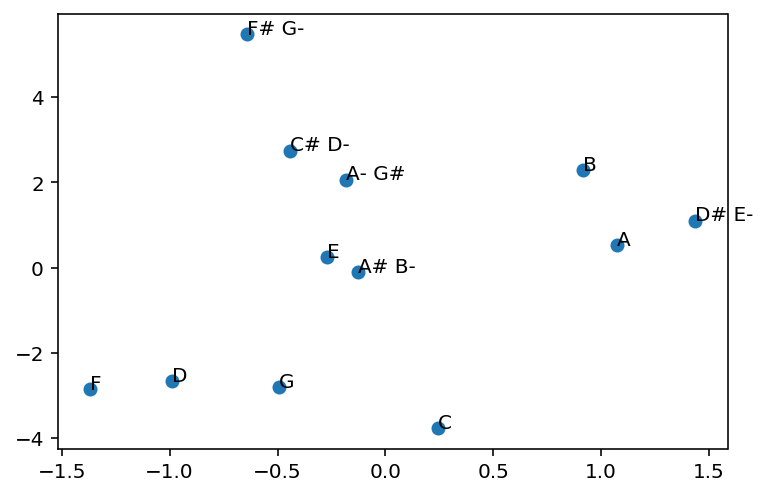

In [69]:
plt.scatter(mean_fifth.iloc[:,0].to_numpy(), mean_fifth.iloc[:,1].to_numpy())
for i in range(12):
    key = mean_fifth.index.values[i]
    plt.text(mean_fifth.iloc[i,0], mean_fifth.iloc[i,1], value2majors[key])
plt.show()

In [44]:
mean_fifth.index.values

array([-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.])